In [1]:
# import libraries
import torch
import torch.nn as nn
import torchmetrics
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.tensorboard import SummaryWriter

import os 
import sys
import wget 
import logging
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from pathlib import Path
from datetime import datetime

/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NOW_STR = datetime.now().strftime("%Y%m%d_%H%M%S")

DATA_DIR = Path('../../data')
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir()

LOG_DIR = Path('../../logs')
if not LOG_DIR.is_dir():
    LOG_DIR.mkdir()

MODELS_DIR = Path('../../models')
if not MODELS_DIR.is_dir():
    MODELS_DIR.mkdir()

TENSORBOARD_DIR = Path('../../tensorboards')
if not TENSORBOARD_DIR.is_dir():
    TENSORBOARD_DIR.mkdir()

In [3]:
CHECKPOINT_FILE_NAME = f"04_tinyvgg_nn_pt_v2_{NOW_STR}.pt"
PLOT_FILE_PATH = MODELS_DIR.joinpath(f"04_tinyvgg_nn_pt_v2_{NOW_STR}.png")

CHECKPOINT_FILE_PATH = MODELS_DIR.joinpath(CHECKPOINT_FILE_NAME)
LOG_FILE_PATH = LOG_DIR.joinpath(f"04_tinyvgg_nn_pt_v2_{NOW_STR}.log")


In [4]:
## LOGGING CONFIGURATION
logging.basicConfig(
    level=logging.INFO,
    datefmt="%a, %d %b %Y %H:%M:%S",
    format="[%(asctime)s.%(msecs)03d] %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(filename=LOG_FILE_PATH, mode="w"),
        logging.StreamHandler()
    ]
)

In [5]:
# torch program
logging.info("- PyTorch Program -")

# created date
logging.info("Created date: 2023-08-03 17:48:15")

# modified date
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
logging.info(f"Modified date: {now}")

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"Available Device: {device}")

# num gpus
num_gpus = torch.cuda.device_count()
logging.info(f"Available GPUs: {num_gpus}" if num_gpus > 1 else f"Available GPU: {num_gpus}")

# num cpus
num_cpus = os.cpu_count()
logging.info(f"Available CPUs {num_cpus}")

# check torch version
logging.info(f"Torch version: {torch.__version__}")

# check torchvision version
logging.info(f"Torchvision version: {torchvision.__version__}")

[Thu, 31 Aug 2023 20:05:32.562] INFO - - PyTorch Program -
[Thu, 31 Aug 2023 20:05:32.563] INFO - Created date: 2023-08-03 17:48:15
[Thu, 31 Aug 2023 20:05:32.563] INFO - Modified date: 2023-08-31 20:05:32
[Thu, 31 Aug 2023 20:05:33.419] INFO - Available Device: cuda
[Thu, 31 Aug 2023 20:05:33.420] INFO - Available GPU: 1
[Thu, 31 Aug 2023 20:05:33.420] INFO - Available CPUs 8
[Thu, 31 Aug 2023 20:05:33.421] INFO - Torch version: 1.12.1
[Thu, 31 Aug 2023 20:05:33.421] INFO - Torchvision version: 0.13.1


In [6]:
### DATASET 
DATASET_URL = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"
DATASET_ZIPFILE_NAME = "pizza_steak.zip"
DATASET_FOLDER_NAME = "pizza_steak"

DATASET_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_ZIPFILE_NAME)
DATASET_FOLDER_PATH = DATA_DIR.joinpath(DATASET_FOLDER_NAME)

In [7]:
### DATASET DOWNLOADING
if DATASET_ZIPFILE_PATH.is_file():
    logging.info(f"The file {DATASET_ZIPFILE_NAME} already downloaded. Skipped downloading.")
else:
    try:
        logging.info(f"The file {DATASET_ZIPFILE_NAME} is downloading...")
        wget.download(url=str(DATASET_URL), out=str(DATA_DIR))
    
    except Exception as error:
        logging.error(f"Caught this error: {error} when downloading {DATASET_URL}")

### EXTRACTING THE ZIPFILE
if DATASET_FOLDER_PATH.is_dir():
    logging.info(f"The {DATASET_ZIPFILE_NAME} is extracted. Skipped extracting.")
else:
    try:
        logging.info(f"The file {DATASET_ZIPFILE_NAME} is extracting...")
        zipper = ZipFile(DATASET_ZIPFILE_PATH)
        zipper.extractall(path=str(DATA_DIR))
        zipper.close()
        logging.info(f"The {DATASET_ZIPFILE_NAME} is extracted successfully.")
    except Exception as error:
        logging.error(f"Caught this error: {error} when extracting the {DATASET_ZIPFILE_NAME}")


[Thu, 31 Aug 2023 20:05:33.439] INFO - The file pizza_steak.zip already downloaded. Skipped downloading.
[Thu, 31 Aug 2023 20:05:33.440] INFO - The pizza_steak.zip is extracted. Skipped extracting.


In [8]:
### TRAIN DIRECTORY
TRAIN_DIR = DATASET_FOLDER_PATH.joinpath("train")

# list all images in the training dir
logging.info(f"Scanning {TRAIN_DIR}")
for filepaths, dirnames, filesnames in os.walk(TRAIN_DIR):
    if len(filesnames) > 0:
        logging.info(f"There are {len(filesnames)} images in {filepaths}.")

### TEST DIRECTORY
TEST_DIR = DATASET_FOLDER_PATH.joinpath("test")

# list all images in the training dir
logging.info(f"Scanning {TEST_DIR}")
for filepaths, dirnames, filesnames in os.walk(TEST_DIR):
    if len(filesnames) > 0:
        logging.info(f"There are {len(filesnames)} images in {filepaths}.")

[Thu, 31 Aug 2023 20:05:33.455] INFO - Scanning ../../data/pizza_steak/train
[Thu, 31 Aug 2023 20:05:33.457] INFO - There are 750 images in ../../data/pizza_steak/train/pizza.
[Thu, 31 Aug 2023 20:05:33.459] INFO - There are 750 images in ../../data/pizza_steak/train/steak.
[Thu, 31 Aug 2023 20:05:33.476] INFO - Scanning ../../data/pizza_steak/test
[Thu, 31 Aug 2023 20:05:33.493] INFO - There are 250 images in ../../data/pizza_steak/test/pizza.
[Thu, 31 Aug 2023 20:05:33.496] INFO - There are 250 images in ../../data/pizza_steak/test/steak.


In [9]:
## IMAGEFOLDER

# batch size
BATCH_SIZE = 32
logging.info(f"Batch size: {BATCH_SIZE}")

# train_transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# test_transforn
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# apply transforms with the training directory
train_dataset = ImageFolder(root=TRAIN_DIR, transform=train_transform)

# apply transforms with the testing directory
test_dataset = ImageFolder(root=TEST_DIR, transform=test_transform)

# class names
CLASS_NAMES = train_dataset.classes
logging.info(f"Class names of the {DATASET_FOLDER_NAME} dataset: {CLASS_NAMES}")

# num classes
NUM_CLASSES = len(CLASS_NAMES)
logging.info(f"There are {len(CLASS_NAMES)} in the {DATASET_FOLDER_NAME} dataset")


## DATALOADER

# train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_gpus)

# test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_gpus)

[Thu, 31 Aug 2023 20:05:33.507] INFO - Batch size: 32
[Thu, 31 Aug 2023 20:05:33.513] INFO - Class names of the pizza_steak dataset: ['pizza', 'steak']
[Thu, 31 Aug 2023 20:05:33.513] INFO - There are 2 in the pizza_steak dataset


[Thu, 31 Aug 2023 20:05:33.898] INFO - Shape before converting: torch.Size([3, 224, 224])
[Thu, 31 Aug 2023 20:05:33.901] INFO - Shape after converting: (224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

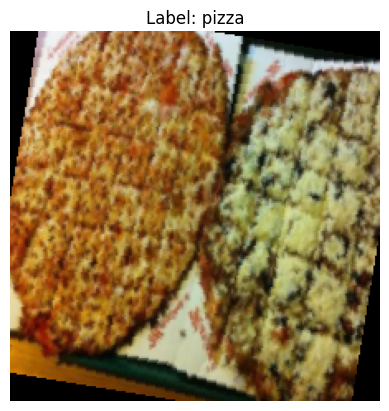

In [10]:
## VISUALISATION
images, labels = next(iter(train_dataloader))

# get one image
image = images[0]
logging.info(f"Shape before converting: {image.shape}")

# from PyTorch shapes to Matplotlib shape
image_np = image.permute(2,1,0).numpy()

# mean 
mean = [0.485, 0.456, 0.406]

# std 
std = [0.229, 0.224, 0.225]

# convert the normalized image to the normal image
image = image_np * std + mean

# clipping 
image = np.clip(image, 0, 1)
logging.info(f"Shape after converting: {image_np.shape}")

# visual on plot
plt.imshow(image)
plt.title(f"Label: {CLASS_NAMES[labels[0]]}")
plt.axis(False)

In [11]:
class EarlyStopping(nn.Module):
    def __init__(self, patience: int = 20, delta: float = 0, verbose: bool = True, filename: str = 'checkpoint.pt', dirpath: Path = Path('checkpoints')) -> None:
        super().__init__()

        self.patience = patience
        self.best_cost = 0.0
        self.delta = delta
        self.counter = 0
        self.verbose = verbose
        self.is_early_stopping = False
        self.filename = filename
        self.dirpath = dirpath

    def save_checkpoint(self, model: nn.Module):
        if not self.dirpath.is_dir():
            self.dirpath.mkdir(parents=True, exist_ok=True)

        file_path = self.dirpath.joinpath(self.filename)
        torch.save(model.state_dict(), file_path)
        logging.info(f"The checkpoint is saved in this path: {self.file_path}")

    def __call__(self, model: nn.Module, val_loss: float = 0.0):
        super().__call__()

        if self.best_cost == None:
            self.best_cost = val_loss
        elif self.delta + self.best_cost < val_loss:
            self.counter += 1
            logging.info(f"Early stopping: {self.counter} out of {self.patience}")

            if self.counter >= self.patience:
                self.save_checkpoint(model=model)
                self.is_early_stopping = True
                self.counter = 0
        else:
            self.best_cost = val_loss

In [12]:
## MODELING

class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=13*13*hidden_units, out_features=len(CLASS_NAMES))
        )
    
    def forward(self, x: torch.Tensor):

        x = self.block_1(x)
        # print(f"block_1: {x.shape}")
        x = self.block_2(x)
        # print(f"block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"classifier: {x.shape}")
        return x



In [13]:
# TRAINING

# set manual seed
torch.manual_seed(42)

# create a model
model = TinyVGG(input_shape=3, hidden_units= 10, output_shape= len(CLASS_NAMES))

# send to device
model.to(device)

# epochs 
epochs = 100

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# results dict
results_dict = {
    "loss": [],
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

# early stopping
early_stopping  = EarlyStopping(delta=0.1, filename=CHECKPOINT_FILE_NAME, dirpath=MODELS_DIR)

# tensorboard
summary_writer = SummaryWriter(log_dir=TENSORBOARD_DIR.joinpath(f"04_tinyvgg_nn_pt_v2_{NOW_STR}"))

# loop-training
for epoch in range(epochs):

    ## TRAINING 
    accumulated_train_acc = 0.0
    accumulated_train_loss = 0.0
    accumulated_train_batches = 0

    for input, output in train_dataloader:

        # send to device
        input, output = input.to(device), output.to(device)

        # train mode
        model.train()

        # forward
        y_logits = model(input)

        # calculate loss
        loss = loss_fn(y_logits.float(), output.long())
        accumulated_train_loss += loss.item()

        # calculate accuracy
        acc = torch.eq(output, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
        accumulated_train_acc += acc 

        # reset gradients
        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # update gradients
        optimizer.step()

        # acccumulate batches
        accumulated_train_batches += 1

    ### TESTING
    accumulated_test_acc = 0.0
    accumulated_test_loss = 0.0
    accumulated_test_batches = 0

    model.eval()
    with torch.inference_mode():

        for input, output in test_dataloader:

            # send to device
            input, output = input.to(device), output.to(device)

            # train mode
            model.train()

            # forward
            y_logits = model(input)

            # calculate loss
            loss = loss_fn(y_logits.float(), output.long())
            accumulated_test_loss += loss.item()

            # calculate accuracy
            acc = torch.eq(output, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
            accumulated_test_acc += acc 

            # acccumulate batches
            accumulated_test_batches += 1

    # training
    train_loss = accumulated_train_loss / accumulated_train_batches
    train_acc = accumulated_train_acc / (BATCH_SIZE * len(train_dataloader))

    # results's dict
    results_dict["loss"].append(train_loss)
    results_dict["accuracy"].append(train_acc)

    # testing 
    test_loss = accumulated_test_loss / accumulated_test_batches
    test_acc = accumulated_test_acc / (BATCH_SIZE * len(test_dataloader))

    # results's dict
    results_dict["val_loss"].append(test_loss)
    results_dict["val_accuracy"].append(test_acc)

    # summary writer
    summary_writer.add_scalar("Epoch/loss", epoch, train_loss)
    summary_writer.add_scalar("Epoch/accuracy", epoch, train_acc)

    summary_writer.add_scalar("Epoch/val_loss", epoch, test_loss)
    summary_writer.add_scalar("Epoch/val_accuracy", epoch, test_acc)

    # print out
    logging.info(f"Epoch: {epoch + 1} / {epochs} | "
                 f"train loss: {train_loss:.5f} | "
                 f"train accuracy: {train_acc:.3f} | "
                 f"test loss: {test_loss:.5f} | "
                 f"test acc: {test_acc:.3f}")
    
    if early_stopping.is_early_stopping:
        logging.info(f"Early stopping at epoch: {epoch}")
        break
    
    
# save a model manually
torch.save(model.state_dict(), CHECKPOINT_FILE_PATH)

# flush summary_writer
summary_writer.flush()
summary_writer.close()

# delete models
# del model

2023-08-31 20:05:35.526703: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
[Thu, 31 Aug 2023 20:05:49.845] INFO - Epoch: 1 / 100 | train loss: 0.58145 | train accuracy: 0.686 | test loss: 0.44800 | test acc: 0.771
[Thu, 31 Aug 2023 20:05:59.729] INFO - Epoch: 2 / 100 | train loss: 0.55412 | train accuracy: 0.723 | test loss: 0.48760 | test acc: 0.742
[Thu, 31 Aug 2023 20:06:09.810] INFO - Epoch: 3 / 100 | train loss: 0.56087 | train accuracy: 0.727 | test loss: 0.46912 | test acc: 0.766
[Thu, 31 Aug 2023 20:06:20.609] INFO - Epoch: 4 / 100 | train loss: 0.55291 | train accuracy: 0.726 | test loss: 0.47204 | test acc: 0.773
[Thu, 31 Aug 2023 20:06:32.295] INFO - Epoch: 5 / 100 | train loss: 0.56081 | train accuracy: 0.718 | test loss: 0.45380 | test acc: 0.773
[Thu, 31 Au

/tmp/ipykernel_10666/4056791338.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(PLOT_FILE_PATH, box_inches="tight")


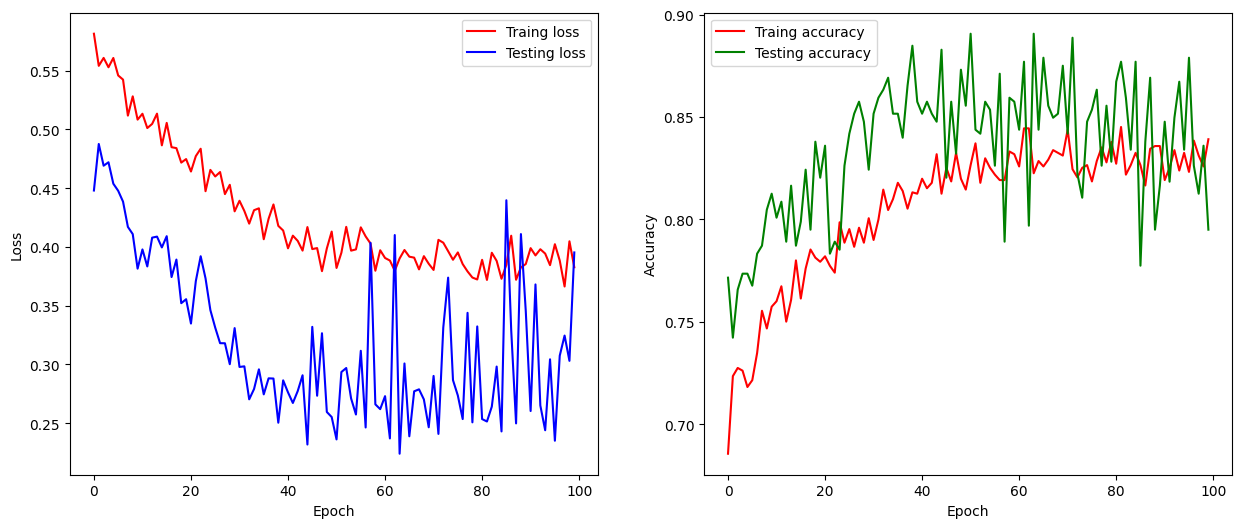

In [14]:
## VISUALIZATION
plt.figure(figsize=(15, 6))

# losses of training and testing 
loss = results_dict["loss"]
val_loss = results_dict["val_loss"]

# accuracy of training and testing 
acc = results_dict["accuracy"]
val_acc = results_dict["val_accuracy"]

# epochs
epochs_list = list(range(len(loss)))

# plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_list, loss, c="r", label="Traing loss")
plt.plot(epochs_list, val_loss, c="b", label="Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# plot losses
plt.subplot(1, 2, 2)
plt.plot(epochs_list, acc, c="r", label="Traing accuracy")
plt.plot(epochs_list, val_acc, c="g", label="Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# save the plot
plt.savefig(PLOT_FILE_PATH, box_inches="tight")

In [15]:
## TORCHMETRICS
batch_images, batch_labels = next(iter(test_dataloader))
y_logits = model(batch_images.to(device))
y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

# estimate accuracy
acc = torchmetrics.functional.accuracy(y_preds, batch_labels.to(device), task="multiclass", num_classes=2)

acc

tensor(0.6250, device='cuda:0')

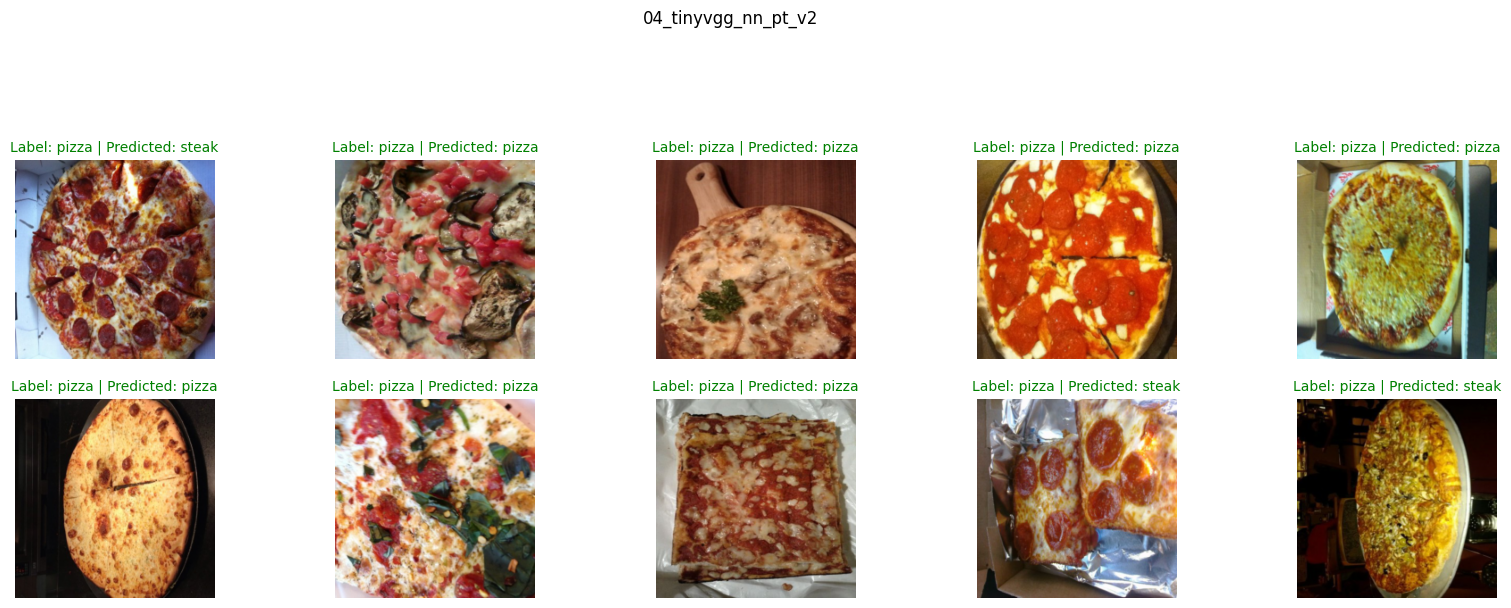

In [16]:
## VISUALISATION OF PREDICTIONS
plt.figure(figsize=(20, 15))
plt.suptitle("04_tinyvgg_nn_pt_v2")
for i, image in enumerate(batch_images[:10]):
    plt.subplot(5, 5, i+1)

    # from PyTorch shapes to Matplotlib shape
    image_np = image.permute(2,1,0).numpy()

    # mean 
    mean = [0.485, 0.456, 0.406]

    # std 
    std = [0.229, 0.224, 0.225]

    # convert the normalized image to the normal image
    image = image_np * std + mean

    # clipping 
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    
    plt.axis('off')
    label = CLASS_NAMES[batch_labels[i]]
    predict = CLASS_NAMES[y_preds[i]]
                        
    if label == predict:
        plt.title(f"Label: {label} | Predicted: {predict}", fontsize=10, c="g")
    else:
        plt.title(f"Label: {label} | Predicted: {predict}", fontsize=10, c="g")

plt.savefig(LOG_DIR.joinpath(f"04_tinyvgg_nn_pt_v2_{NOW_STR}.png"), bbox_inches='tight')
        